Preproccess

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer 
from nltk.corpus import stopwords
from string import punctuation
import re
import math

In [3]:
train = pd.read_csv('train_medical.csv')

In [4]:
sample_size = len(train[train.target == 1])
train_balanced = train[train.target == 1].sample(sample_size).append(train[train.target == 0].sample(sample_size)).reset_index()
train_balanced = train_balanced.drop(columns=['index'])

In [6]:
train_balanced.head()

,qid,question_text,target
0,5d453f877111bb93c195,"Do feminists create imaginary issues, feign su...",1
1,9ff7534b82c798e5b29c,Why do Spanish and Portuguese have such a dark...,1
2,ca8f9449047757effbb8,Why do old Chinese people like to walk backwar...,1
3,991eff101dd210a12069,"If you rob a bank, get caught and sent to jail...",1
4,9f04075cb75bd70daae2,Do Islam and PBUH Mohammed permit sex with dea...,1


In [7]:
train_balanced.shape

(6784, 3)

In [4]:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word.lower() for word in words if word not in stop_words]

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [5]:
# Removing punctuation
train_balanced['question_text_token'] = train_balanced['question_text'].apply(lambda x: remove_punctuation(x))

# Tokenizing the text
train_balanced['question_text_token'] = train_balanced['question_text_token'].apply(lambda x: word_tokenize(x))

# Removing stopwords
train_balanced['question_text_token'] = train_balanced['question_text_token'].apply(lambda x: remove_stopwords(x))

Google Word Vectors

In [6]:
google_word2vec = '/home/james/MED277/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

In [7]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load_word2vec_format(google_word2vec, binary=True)

In [8]:
def Vectorization(question_token):
    words = [i for i in question_token if i in word2vec_model]
    vector_representations = [word2vec_model[i] for i in words]
    return vector_representations

In [9]:
def Cleaner(tokens):
    tokens = [word for word in tokens if word in word2vec_model]
    return ' '.join(tokens)

In [10]:
train_balanced['question_text_vector'] = train_balanced['question_text_token'].apply(Vectorization)

In [11]:
train_balanced['question_text_clean'] = train_balanced['question_text_token'].apply(Cleaner)

LSTM

In [12]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [13]:
train_balanced = train_balanced.sample(frac=1).reset_index()
train_balanced = train_balanced.drop(columns=['index'])
fraction = 0.5
train_balanced_train = train_balanced.iloc[:int(fraction*len(train_balanced))]
train_balanced_test = train_balanced.iloc[int(fraction*len(train_balanced)):]
Y_train = np.array(train_balanced_train['target'])

In [14]:
vocab_size = len(set([i for j in list(train_balanced_train['question_text_clean'])for i in j.split(' ')]))

In [15]:
### Create sequence
vocabulary_size = vocab_size
tokenizer = Tokenizer(num_words= vocab_size)
tokenizer.fit_on_texts(train_balanced_train['question_text_clean'])
sequences = tokenizer.texts_to_sequences(train_balanced_train['question_text_clean'])
data = pad_sequences(sequences, maxlen=32)

In [16]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = word2vec_model[word]
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=32, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(300))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(data, Y_train, validation_split=0.4, epochs = 3)

Train on 2035 samples, validate on 1357 samples
Epoch 1/3
2035/2035 [==============================] - 2s 1ms/step - loss: 0.4456 - acc: 0.8241 - val_loss: 0.3138 - val_acc: 0.8828
Epoch 2/3
2035/2035 [==============================] - 1s 649us/step - loss: 0.2711 - acc: 0.8850 - val_loss: 0.2974 - val_acc: 0.8902
Epoch 3/3
2035/2035 [==============================] - 1s 654us/step - loss: 0.1943 - acc: 0.9337 - val_loss: 0.3143 - val_acc: 0.8895


In [19]:
sequences_test = tokenizer.texts_to_sequences(train_balanced_test['question_text_clean'])
data_test = pad_sequences(sequences_test, maxlen=32)
result = model.predict_classes(data_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

In [21]:
probs = model.predict(data_test).ravel()
fpr, tpr, _ = roc_curve(train_balanced_test['target'], probs)
auc = roc_auc_score(train_balanced_test['target'], probs)

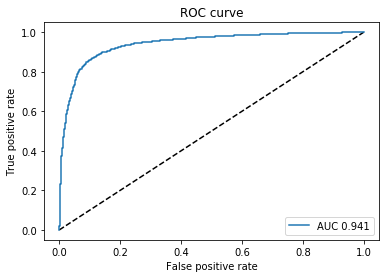

In [22]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
f1_score(train_balanced_test['target'], result)

0.8772348033373063